# Example of loading and training

In [1]:
import csv
import cv2
import numpy as np
import sklearn

samples = []
with open('./driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for i, line in enumerate(reader):
        if i!=0:
            samples.append(line)

from sklearn.model_selection import train_test_split
train_samples, validation_samples = train_test_split(samples, test_size=0.2)

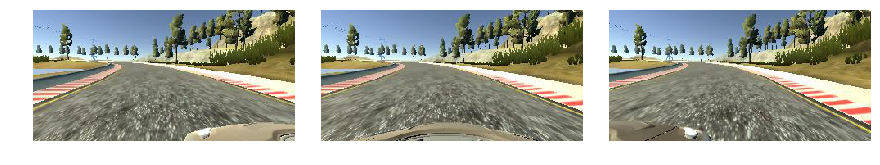

In [7]:
import matplotlib.pyplot as plt
import random 
%matplotlib inline

fig, axs = plt.subplots(1,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
index = random.randint(0, len(train_samples))

imlist = [1,0,2]
for i in range(3):
    name = './IMG/'+samples[index][imlist[i]].split('/')[-1] 
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    axs[i].imshow(image)
    axs[i].axis('off')

In [8]:
def random_brightness(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    brightness = .25 + np.random.uniform()
    image[:,:,2] = image[:,:,2] * brightness
    image = cv2.cvtColor(image, cv2.COLOR_HSV2RGB)
    return image

def preprocess(img):
    # original shape: 160x320x3, input shape for neural net: 66x200x3
    new_img = img[50:140,:,:]
    # Random brightness
    new_img = random_brightness(new_img)
    # scale to 66x200x3 (same as nVidia)
    new_img = cv2.resize(new_img,(200, 66), interpolation = cv2.INTER_AREA)
    # convert to YUV color space (as nVidia paper suggests)
    new_img = cv2.cvtColor(new_img, cv2.COLOR_RGB2YUV)
    return new_img

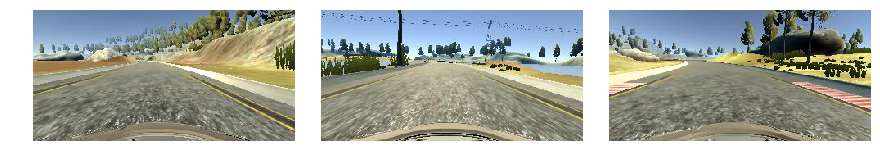

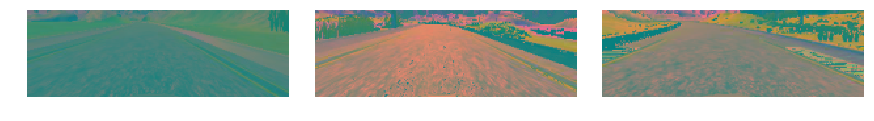

In [10]:
fig, axs = plt.subplots(1,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
images=[]
for i in range(3):
    index = random.randint(0, len(train_samples))
    name = './IMG/'+samples[index][0].split('/')[-1] 
    image = cv2.imread(name)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    images.append(image)
    axs[i].imshow(image)
    axs[i].axis('off')
    
fig, axs = plt.subplots(1,3, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.1)
axs = axs.ravel()
for i in range(3):
    image = preprocess(images[i])
    axs[i].imshow(image)
    axs[i].axis('off') 

In [ ]:
def generator(samples, batch_size=32, correction=0.25):
    num_samples = len(samples)
    straight_num = 0
    while 1: # Loop forever so the generator never terminates
        sklearn.utils.shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            measurments = []
            for batch_sample in batch_samples:
                               
                ## Checking the angle
                center_angle = float(batch_sample[3])
                if abs(center_angle) < 0.1:
                    straight_num += 1
                if straight_num > 0.5*num_samples:
                    while abs(center_angle) < 0.1:
                        batch_sample = samples[random.randrange(num_samples)]
                        center_angle = float(batch_sample[3])
               ##
                        
                name = './IMG/'+batch_sample[0].split('/')[-1] 
                center_image = cv2.imread(name)
                center_image = cv2.cvtColor(center_image, cv2.COLOR_BGR2RGB)
                center_image = preprocess(center_image)
                images.append(center_image)
                measurments.append(center_angle)
                
                name = './IMG/'+batch_sample[1].split('/')[-1]
                left_image = cv2.imread(name)
                left_image = cv2.cvtColor(left_image, cv2.COLOR_BGR2RGB)
                left_image = preprocess(left_image)
                left_angle = center_angle+correction
                images.append(left_image)
                measurments.append(left_angle)
                
                name = './IMG/'+batch_sample[2].split('/')[-1]
                right_image = cv2.imread(name)
                right_image = cv2.cvtColor(right_image, cv2.COLOR_BGR2RGB)
                right_image = preprocess(right_image)
                right_angle = center_angle-correction
                images.append(right_image)
                measurments.append(right_angle)
                
            augmented_images = []
            augmented_measurements = []
            for image, measurement in zip(images, measurments):
                augmented_images.append(image)
                augmented_measurements.append(measurement)
                augmented_images.append(cv2.flip(image,1))
                augmented_measurements.append(measurement*-1.0)
            # trim image to only see section with road
            X_train = np.array(augmented_images)
            y_train = np.array(augmented_measurements)
            yield sklearn.utils.shuffle(X_train, y_train)

In [ ]:
from keras.models import Sequential
from keras.layers import Flatten, Dense, Lambda, Convolution2D, Cropping2D
from keras.layers.pooling import MaxPooling2D

model = Sequential()
model.add(Lambda(lambda x: (x / 127.5) - 1.0, input_shape=(66,200,3)))
model.add(Convolution2D(24,5,5, border_mode='valid', subsample=(2,2), activation='relu'))
model.add(Convolution2D(36,5,5, border_mode='valid', subsample=(2,2), activation='relu'))
model.add(Convolution2D(48,5,5, border_mode='valid', subsample=(2,2), activation='relu'))
model.add(Convolution2D(64,3,3, border_mode='valid', subsample=(1,1), activation='relu'))
model.add(Convolution2D(64,3,3, border_mode='valid', subsample=(1,1), activation='relu'))
model.add(Flatten())
model.add(Dense(100))
model.add(Dropout(.5))
model.add(Dense(50))
model.add(Dropout(.5))
model.add(Dense(10))
model.add(Dropout(.5))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

train_generator = generator(train_samples, batch_size=32)
validation_generator = generator(validation_samples, batch_size=32)

model.fit_generator(train_generator, samples_per_epoch= len(train_samples)*6,
                    validation_data=validation_generator, 
                    nb_val_samples=len(validation_samples)*6, nb_epoch=5)

model.save('model.h5')